# Models

## GloVe

In [286]:
!pip install spacy
!python -m spacy download en_core_web_md

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
2023-06-05 22:22:49.591930: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 15.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [287]:
import spacy

glove_model = spacy.load('en_core_web_md')

def word_embedding_glove(sentence):
  return glove_model(sentence).vector

## FastText
Skipping for now, take way too much RAM

## ELMo

In [288]:
!pip install tensorflow
!pip install tensorflow_hub
!pip install numpy
!pip install sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached sklearn-0.0.post5.tar.gz (3.7 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post5-py3-none-any.whl size=2950 sha256=7fdef2ab2d7cd0c949d923c2ec1ffc1590375c5688e707926751cf844549d25f
  Stored in directory: /root/.cache/pip/wheels/38/1f/8d/4f812c590e074c1e928f5cec67bf5053b71f38e2648739403a
Successfully built sklearn


In [289]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

elmo_model = hub.load("https://tfhub.dev/google/elmo/3")
tf.compat.v1.enable_eager_execution()

def word_embedding_elmo(sentence):
    embeddings = elmo_model.signatures["default"](tf.constant([sentence]))["default"]
    return embeddings.numpy().squeeze()

## BERT

In [290]:
!pip install transformers 
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Splitting the sentence is too time consuming

In [316]:
from transformers import BertModel, BertTokenizer
import torch

# Load BERT model and tokenizer
model_name = 'bert-large-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
bert_model = BertModel.from_pretrained(model_name)

def word_embedding_bert(sentence):
  tokens = tokenizer.encode(sentence, add_special_tokens=True, max_length=512, truncation=True)
  ids = torch.tensor(tokens).unsqueeze(0)
  with torch.no_grad():
    return bert_model(ids).last_hidden_state.mean(dim=1).squeeze()

Some weights of the model checkpoint at bert-large-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## GPT

In [292]:
!pip install transformers
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [293]:
from transformers import GPT2Tokenizer, GPT2Model
import torch

model_name = 'gpt2'
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
gpt_model = GPT2Model.from_pretrained(model_name)
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

def word_embedding_gpt(sentence):
    encoded = tokenizer(sentence, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
      outputs = gpt_model(**encoded)
      return outputs.last_hidden_state.mean(dim=1).numpy()

# Scores

In [294]:
models = ['glove', 'elmo', 'bert', 'gpt']

## Cosine Similarity

In [295]:
!pip install sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [296]:
from sklearn.metrics.pairwise import cosine_similarity

# [-1, 1]. higher value -> higher similarity
def get_cosine_similarity(job_embedding, resume_embedding, model):
  
  if model not in models:
    raise Exception('Model Not Found!')

  if model in ['fasttext', 'glove', 'bert']:
    return cosine_similarity(job_embedding.reshape(1, -1), resume_embedding.reshape(1, -1))[0, 0]
    
  elif model == 'elmo':
    return cosine_similarity([job_embedding], [resume_embedding])[0][0]

  # GPT model
  else:
    return cosine_similarity(job_embedding, resume_embedding)[0][0]

## Eucledian Distance

In [297]:
!pip install sklearn
!pip install scipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [298]:
from scipy.spatial.distance import euclidean
from sklearn.metrics.pairwise import euclidean_distances

# non-negative value, lower the value -> higher the similarity
def get_eucledian_distance(job_embedding, resume_embedding, model):
  
  if model not in models:
    raise Exception('Model Not Found!')

  if model in ['fasttext', 'elmo']:
    return euclidean(job_embedding, resume_embedding)
  
  # GloVe, BERT, or GPT
  else:
    return np.linalg.norm(job_embedding - resume_embedding)

## Pearson Correlation Coefficient

In [299]:
!pip install scipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [300]:
from scipy.stats import pearsonr

# -1 to 1. -1 perfect negative linear relationship, 0 none, 1 perfect positive
def get_pearson_coefficient(job_embedding, resume_embedding, model):
  
  if model not in models:
    raise Exception('Model Not Found!')

  if model == 'gpt':
    coeff, _ = pearsonr(job_embedding[0], resume_embedding[0])
    return coeff
  
  else:
    coeff, _ = pearsonr(job_embedding, resume_embedding)
    return coeff
    

## Manhattan Distance

In [301]:
!pip install scipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [302]:
from scipy.spatial.distance import cityblock

max_length = 10000

# non-negative. higher value -> less similar
def get_manhattan_distance(job_embedding, resume_embedding, model):
  
  if model not in models:
    raise Exception('Model Not Found!')

  if model in ['fasttext', 'glove', 'elmo']:
    return cityblock(job_embedding, resume_embedding)

  # BERT or GPT
  else:
    job_embedding = np.pad(job_embedding, (0, max_length - len(job_embedding)))
    resume_embedding = np.pad(resume_embedding, (0, max_length - len(resume_embedding)))
    return np.linalg.norm(job_embedding - resume_embedding, ord=1)

# Main

In [303]:
# Steps:
# 1. Job Desc
# 2. Get n random resumes
# 3. For each, generate the dataframe w models and scores
# 4. Rank the n resumes
# 5. TDIDF for each of them
# 
# Helpers
# 1. WordCloud for each resume
# 2. TDIDF WordCloud

In [304]:
import os
from google.colab import drive

In [305]:
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [306]:
INPUT_FOLDER = '/content/gdrive/Shareddrives/CSE 144 DATA/DATA'

In [307]:
import pandas as pd
import re
import nltk

In [308]:
# Read the Datasets
jobs_ds = pd.read_csv(INPUT_FOLDER + '/Final Job Dataset.csv', encoding='utf-8')
resume_ds = pd.read_csv(INPUT_FOLDER + '/Clean Resume Guara.csv', encoding='utf-8')

In [309]:
jobs_len = jobs_ds.shape[0]
resume_len = resume_ds.shape[0]

In [310]:
import random

In [311]:
job_id = random.randint(0, jobs_len-1)                             # Select a random job description

num_resumes = 10                                                   # Number of resumes to sample
resume_ids = random.sample(range(0, resume_len-1), num_resumes)    # Select random resumes

In [312]:
job_description     = input('Enter job description: ')
resume_descriptions = [resume_ds['Resume'][i] for i in resume_ids]

Enter job description: Strong mathematical skills to help collect, measure, organize and analyze data  Knowledge of programming languages like SQL, Oracle, R, MATLAB, and Python Technical proficiency regarding database design development, data models, techniques for data mining, and segmentation. Experience in handling reporting packages like Business Objects, programming (Javascript, XML, or ETL frameworks), databases Proficiency in statistics and statistical packages like Excel, SPSS, SAS to be used for data set analyzing Adept at using data processing platforms like Hadoop and Apache Spark Knowledge of data visualization software like Tableau, Qlik Knowledge of how to create and apply the most accurate algorithms to datasets in order to find solutions  Problem-solving skills Accuracy and attention to detail Adept at queries, writing reports, and making presentations Team-working skills Verbal and Written communication skills Proven working experience in data analysis


### Get scores

In [313]:
# Return a formatted DataFrame, given a dictionary
def dict_to_df(result_dict):
  # Rename Rows
  result_dict['GPT'] = result_dict.pop('gpt')
  result_dict['BERT'] = result_dict.pop('bert')
  result_dict['GloVe'] = result_dict.pop('glove')
  result_dict['ELMo'] = result_dict.pop('elmo')

  # Create the dataframe
  result_df  = pd.DataFrame.from_dict(result_dict, orient='index')
  result_df.columns = ['Cosine Similarity', 'Eucledian Distance', 'Pearson Correlation Coefficient', 'Manhattan Distance', 'Weighted Combined Score']

  return result_df

In [314]:
all_candidates_result_df = []

# Generates the resulting dataframes (might take about 6-7 mins for 10 resumes)
def generate_df_results():

  # get embeddings for job description
  job_embeddings = {
                    'bert': word_embedding_bert(job_description), 
                    'elmo' : word_embedding_elmo(job_description),
                    'gpt'  : word_embedding_gpt(job_description),
                    'glove' : word_embedding_glove(job_description)
                    }

  resume_embeddings = {}

  for idx, resume in enumerate(resume_descriptions):
    print('Resume no. : ', idx)

    result_dict = {}

    # get embeddings by each model
    resume_embeddings['bert']  = word_embedding_bert(resume)
    resume_embeddings['gpt']   = word_embedding_gpt(resume)
    resume_embeddings['elmo']  = word_embedding_elmo(resume)
    resume_embeddings['glove'] = word_embedding_glove(resume)

    # loop over each model, and get all scores for that model
    for model in models:
      cos_sim    = get_cosine_similarity(job_embeddings[model], resume_embeddings[model], model)
      euc_dis    = get_eucledian_distance(job_embeddings[model], resume_embeddings[model], model)
      pear_coeff = get_pearson_coefficient(job_embeddings[model], resume_embeddings[model], model)
      manh_dis   = get_manhattan_distance(job_embeddings[model], resume_embeddings[model], model)

      result_dict[model] = [cos_sim, euc_dis, pear_coeff, manh_dis,
                            0+cos_sim-euc_dis+pear_coeff-manh_dis]  # total score, higher the better
    
    all_candidates_result_df.append(dict_to_df(result_dict))


In [317]:
generate_df_results()

Resume no. :  0
Resume no. :  1
Resume no. :  2
Resume no. :  3
Resume no. :  4
Resume no. :  5
Resume no. :  6
Resume no. :  7
Resume no. :  8
Resume no. :  9


In [318]:
# See dataframes of all resumes
def df_results():
  for i in range(len(all_candidates_result_df)):
    print('DF OF RESUME #', i)
    display(all_candidates_result_df[i])
    print()

In [319]:
df_results()

DF OF RESUME # 0


,Cosine Similarity,Eucledian Distance,Pearson Correlation Coefficient,Manhattan Distance,Weighted Combined Score
GPT,0.999273,11.470300,0.999270,7.579552,-17.051308
BERT,0.853813,4.672481,0.853792,120.524345,-123.489222
GloVe,0.726769,22.482126,0.727252,315.735840,-336.763945
ELMo,0.737566,6.501573,0.740021,165.295105,-170.319092



DF OF RESUME # 1


,Cosine Similarity,Eucledian Distance,Pearson Correlation Coefficient,Manhattan Distance,Weighted Combined Score
GPT,0.999604,8.899227,0.999603,8.238235,-15.138256
BERT,0.840099,4.917547,0.840081,127.212418,-130.449784
GloVe,0.829322,18.242273,0.829614,251.628799,-268.212136
ELMo,0.797163,5.692249,0.798058,143.757370,-147.854398



DF OF RESUME # 2


,Cosine Similarity,Eucledian Distance,Pearson Correlation Coefficient,Manhattan Distance,Weighted Combined Score
GPT,0.999110,26.218071,0.999108,21.795692,-46.015546
BERT,0.849374,5.066459,0.849376,129.363678,-132.731387
GloVe,0.889080,15.179949,0.889605,209.176270,-222.577533
ELMo,0.833564,5.316769,0.834219,135.986801,-139.635787



DF OF RESUME # 3


,Cosine Similarity,Eucledian Distance,Pearson Correlation Coefficient,Manhattan Distance,Weighted Combined Score
GPT,0.999497,15.835635,0.999495,12.629944,-26.466587
BERT,0.792765,5.869811,0.792745,149.192123,-153.476425
GloVe,0.870887,16.293528,0.871151,223.148010,-237.699499
ELMo,0.744336,6.769690,0.744832,169.794373,-175.074894



DF OF RESUME # 4


,Cosine Similarity,Eucledian Distance,Pearson Correlation Coefficient,Manhattan Distance,Weighted Combined Score
GPT,0.999362,11.166138,0.999360,7.581131,-16.748547
BERT,0.839135,4.936246,0.839112,125.980240,-129.238238
GloVe,0.706051,22.939955,0.707693,323.089478,-344.615688
ELMo,0.688247,7.315026,0.689514,186.371796,-192.309060



DF OF RESUME # 5


,Cosine Similarity,Eucledian Distance,Pearson Correlation Coefficient,Manhattan Distance,Weighted Combined Score
GPT,0.999013,25.112934,0.999010,20.264168,-43.379079
BERT,0.835898,5.182183,0.835883,132.153931,-135.664333
GloVe,0.793540,20.065170,0.793530,279.227631,-297.705731
ELMo,0.789416,6.059212,0.791144,156.233932,-160.712585



DF OF RESUME # 6


,Cosine Similarity,Eucledian Distance,Pearson Correlation Coefficient,Manhattan Distance,Weighted Combined Score
GPT,0.998979,14.731807,0.998976,10.242088,-22.975941
BERT,0.815639,5.262902,0.815613,135.698181,-139.329831
GloVe,0.667806,24.134001,0.668008,345.176422,-367.974609
ELMo,0.650450,7.617260,0.651045,193.745468,-200.061234



DF OF RESUME # 7


,Cosine Similarity,Eucledian Distance,Pearson Correlation Coefficient,Manhattan Distance,Weighted Combined Score
GPT,0.999718,14.102312,0.999717,12.217522,-24.320399
BERT,0.796426,5.892999,0.796411,151.187927,-155.488089
GloVe,0.814904,19.027563,0.815545,265.122131,-282.519245
ELMo,0.669314,7.253571,0.669899,183.551025,-189.465383



DF OF RESUME # 8


,Cosine Similarity,Eucledian Distance,Pearson Correlation Coefficient,Manhattan Distance,Weighted Combined Score
GPT,0.997676,30.198921,0.997669,23.187744,-51.391320
BERT,0.859664,4.601344,0.859647,118.489838,-121.371870
GloVe,0.747527,21.792324,0.747829,304.779785,-325.076753
ELMo,0.677775,7.231429,0.678181,184.723846,-190.599319



DF OF RESUME # 9


,Cosine Similarity,Eucledian Distance,Pearson Correlation Coefficient,Manhattan Distance,Weighted Combined Score
GPT,0.999696,11.491505,0.999696,9.082619,-18.574731
BERT,0.848535,4.858735,0.848521,125.764870,-128.926549
GloVe,0.806874,19.401756,0.806891,265.110138,-282.898130
ELMo,0.770197,6.306593,0.770198,162.200150,-166.966348


### Rank the resumes

In [320]:
def rank_resumes():
  sum_array = []
  for i in range(len(all_candidates_result_df)):
    sum_array.append(all_candidates_result_df[i]['Weighted Combined Score'].sum())

  sorted_array = sorted(enumerate(sum_array), key=lambda x: x[1], reverse=True)
  return sorted_array

In [321]:
ranked = rank_resumes()
print(ranked)

[(2, -540.960253104296), (1, -561.6545745115187), (3, -592.717405390283), (9, -597.3657572384698), (5, -637.4617284561663), (0, -647.6235669858187), (7, -651.7931166102239), (4, -682.9115336227227), (8, -688.4392623311392), (6, -730.3416147326095)]


In [322]:
# since our resume are all anonymous, we have no way to reference to a specific resume as of now
# in the future we should use id-ed resume for actual implementation
import textwrap

def visualize_matching_resumes(ls_ranked):
  print('Job Description: ', job_description)
  print('Top 10 Matching Resume(s): ')
  print('|',' '*47,'Resume',' '*47,'| \u2211 Cosine | \u2211 Eucledian | \u2211 Pearson | \u2211 Manhattan | Weighted Combined Score |')

  sep = '|'

  for idx, score in ls_ranked:
    wrapped = textwrap.shorten(resume_descriptions[idx], 
                               width=100, placeholder="...")
    ls_pr = ["{:.4f}".format(sum(x_val)) for x_title, x_val in all_candidates_result_df[idx].items()]
    ls_pr = [wrapped] + ls_pr
   
    # Format and align the elements of the list
    f_list = "|{:<104s}|{:<10s}|{:<13s}|{:<11s}|{:<13s}|{:<25s}|".format(*ls_pr)
    print(f_list)
    

In [323]:
visualize_matching_resumes(ranked)

Job Description:  Strong mathematical skills to help collect, measure, organize and analyze data  Knowledge of programming languages like SQL, Oracle, R, MATLAB, and Python Technical proficiency regarding database design development, data models, techniques for data mining, and segmentation. Experience in handling reporting packages like Business Objects, programming (Javascript, XML, or ETL frameworks), databases Proficiency in statistics and statistical packages like Excel, SPSS, SAS to be used for data set analyzing Adept at using data processing platforms like Hadoop and Apache Spark Knowledge of data visualization software like Tableau, Qlik Knowledge of how to create and apply the most accurate algorithms to datasets in order to find solutions  Problem-solving skills Accuracy and attention to detail Adept at queries, writing reports, and making presentations Team-working skills Verbal and Written communication skills Proven working experience in data analysis
Top 10 Matching Resu

### TF-IDF Visualizer

In [326]:
# reorder the resume description base on their scores
resume_order = [idx for idx, sc in ranked]
print(resume_order)
resume_des_sorted = sorted(resume_descriptions, key=lambda x: resume_order.index(resume_descriptions.index(x)))
print(resume_des_sorted)

[2, 1, 3, 9, 5, 0, 7, 4, 8, 6]
['Technical Summary Knowledge Informatica Power Center ver 9 1 10 ETL Tool Mapping designing usage multiple transformations Integration various data source like SQL Server tables Flat Files etc target data warehouse SQL PLSQL working knowledge Microsoft SQL server 2010 Unix Work Description shell scripting error debugging Job scheduling using Autosys Incident management Change Requests Service JIRA Agile Central Basic knowledge Intellimatch Reconciliation tool Education Details January 2010 January 2014 BTech CSE Sangli Maharashtra Walchand College Engineering October 2009 H C Sangli Maharashtra Willingdon College August 2007 C Achievements Sangli Maharashtra Martin English School ETL Developer Analyst Skill Details ETL Exprience 48 months EXTRACT TRANSFORM LOAD Exprience 48 months INFORMATICA Exprience 48 months MS SQL SERVER Exprience 48 months RECONCILIATION Exprience 48 months Jira Exprience 36 monthsCompany Details company Tata Consultancy Services d

In [327]:
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Calculate TFIDF Scores
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(resume_des_sorted)
feature_names = vectorizer.get_feature_names_out()

In [328]:
# print stats of tfidf
def tfidf_stats():

  # Print for each resume, how important a word is
  # Print the TF-IDF scores for each term in each document
  all_doc_list = []
  for doc_idx, doc in enumerate(resume_des_sorted):
      feature_index = tfidf_matrix[doc_idx].nonzero()[1]
      tfidf_scores = zip(feature_index, [tfidf_matrix[doc_idx, x] for x in feature_index])
      cur_doc_list = []
      for term_idx, score in tfidf_scores:
          cur_doc_list.append((feature_names[term_idx], score))
      all_doc_list.append(sorted(cur_doc_list, key=lambda x: x[1]))
  
  print('Words w their TFIDF Scores')
  print()
  for idx, doc in enumerate(all_doc_list):
    print(f'Resume #{idx}\t:', doc)

In [329]:
tfidf_stats()

Words w their TFIDF Scores

Resume #0	: [('skill', 0.01198764869219893), ('education', 0.01198764869219893), ('monthscompany', 0.013130193644483491), ('developer', 0.01740588756973076), ('engineering', 0.01740588756973076), ('work', 0.01740588756973076), ('ms', 0.01925379176516357), ('school', 0.01925379176516357), ('2014', 0.01925379176516357), ('management', 0.01925379176516357), ('working', 0.01925379176516357), ('microsoft', 0.02143939853702429), ('various', 0.02143939853702429), ('10', 0.02143939853702429), ('company', 0.02397529738439786), ('english', 0.024114365038108702), ('service', 0.024114365038108702), ('job', 0.024114365038108702), ('tables', 0.024114365038108702), ('like', 0.024114365038108702), ('multiple', 0.024114365038108702), ('achievements', 0.02756299665770437), ('august', 0.02756299665770437), ('basic', 0.02756299665770437), ('incident', 0.02756299665770437), ('scheduling', 0.02756299665770437), ('scripting', 0.02756299665770437), ('shell', 0.02756299665770437), (

In [330]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# make wordclouds of each resume according to their tfidf scores
def make_tfidf_clouds():
  
  for i, resume in enumerate(resume_des_sorted):
      tfidf_scores = tfidf_matrix[i].toarray().flatten()
      word_scores = dict(zip(feature_names, tfidf_scores))

      wordcloud = WordCloud(width=300, height=200, background_color='white').generate_from_frequencies(word_scores)

      plt.figure(figsize=(6, 4))
      plt.imshow(wordcloud, interpolation='bilinear')
      plt.axis('off')
      plt.title(f'Resume #{i}')

      # Show the plot
      print()
      plt.show()
      


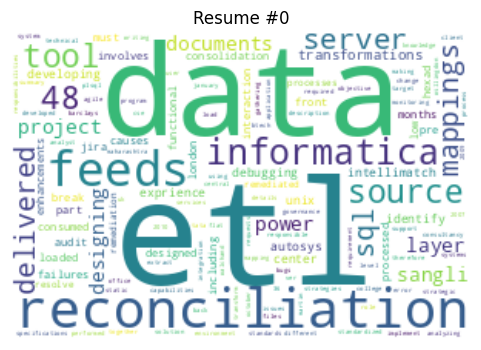

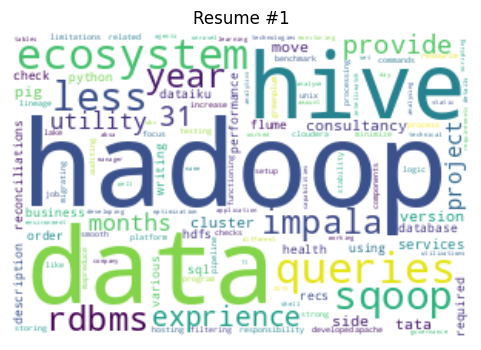

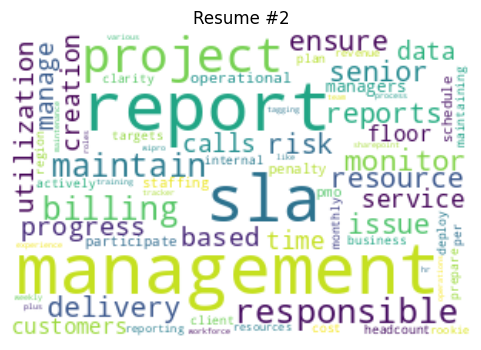

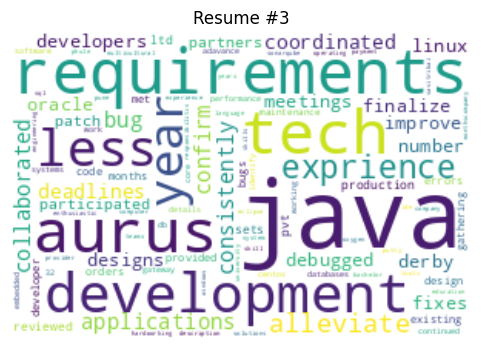

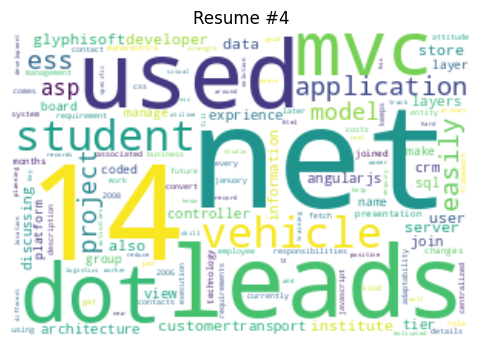

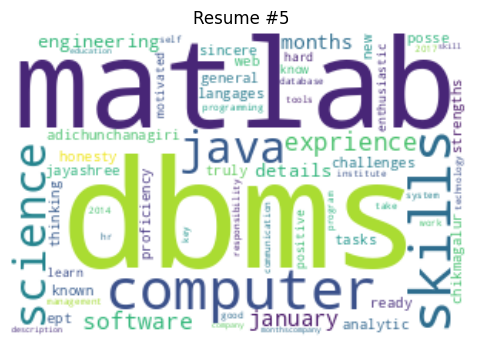

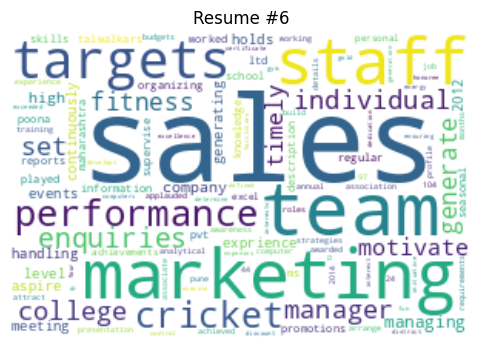

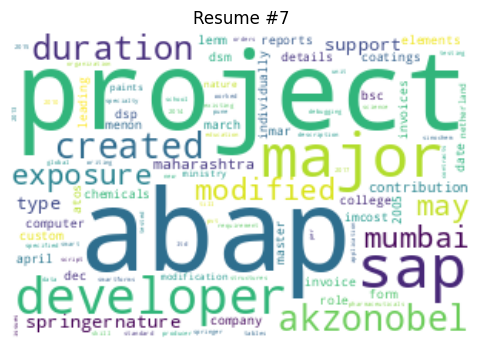

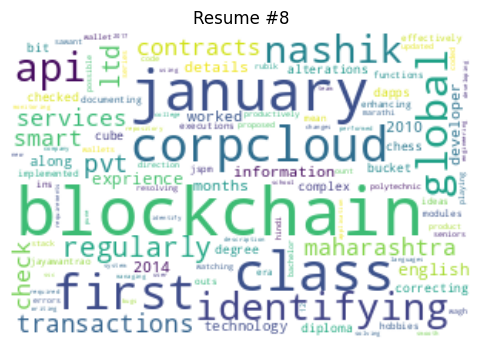

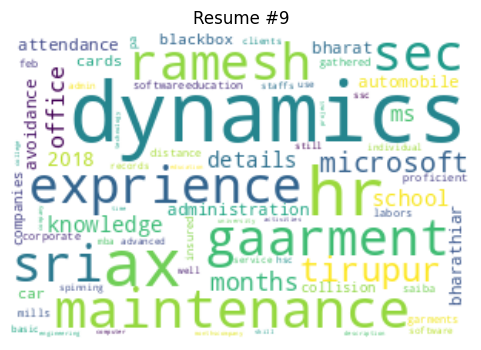

In [331]:
make_tfidf_clouds()

In [332]:
def wordcloud_tfidf_comb():

  word_scores = tfidf_matrix.sum(axis=0).A1
  word_scores_dict = dict(zip(feature_names, word_scores))
  wordcloud = WordCloud(width=800, height=600, background_color='white').generate_from_frequencies(word_scores_dict)

  plt.figure(figsize=(10, 8))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis('off')
  plt.title("Word Cloud of TF-IDF Resumes")

  # Show the plot
  plt.show()

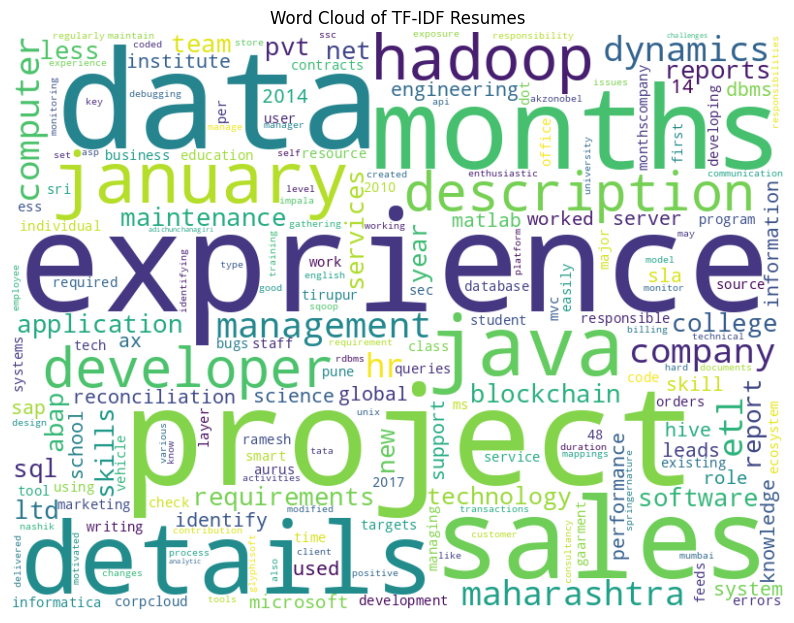

In [333]:
wordcloud_tfidf_comb()